In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from data_loader import DataLoader

sns.set_theme()
sns.set_palette('deep')

DATA_PATH = "./data/all_hourly_data.h5"

data_loader = DataLoader(data_path=DATA_PATH)

In [2]:
import collections

def common_member(l = []):
    el = l[0]
    for i, e in enumerate(l):
        el = np.intersect1d(el, e)
    return el

In [4]:

# TODO determine same list of features accross datasets

import numpy as np

common_features = []
dfs_plot = [data_loader.data_meas.assign(sampling="none")]

for ds_key in data_loader.complete_datasets.keys():
    df = data_loader.complete_datasets[ds_key]
    dfs_plot.append(df.assign(sampling=df.columns[1][0]))
    break

common_features = common_member([df.columns for df in dfs_plot])

df_plot = pd.concat(dfs_plot)[list(common_features)]

In [108]:
common_features

array(['diastolic blood pressure', 'heart rate', 'oxygen saturation',
       'respiratory rate', 'sampling', 'subject_id',
       'systolic blood pressure'], dtype=object)

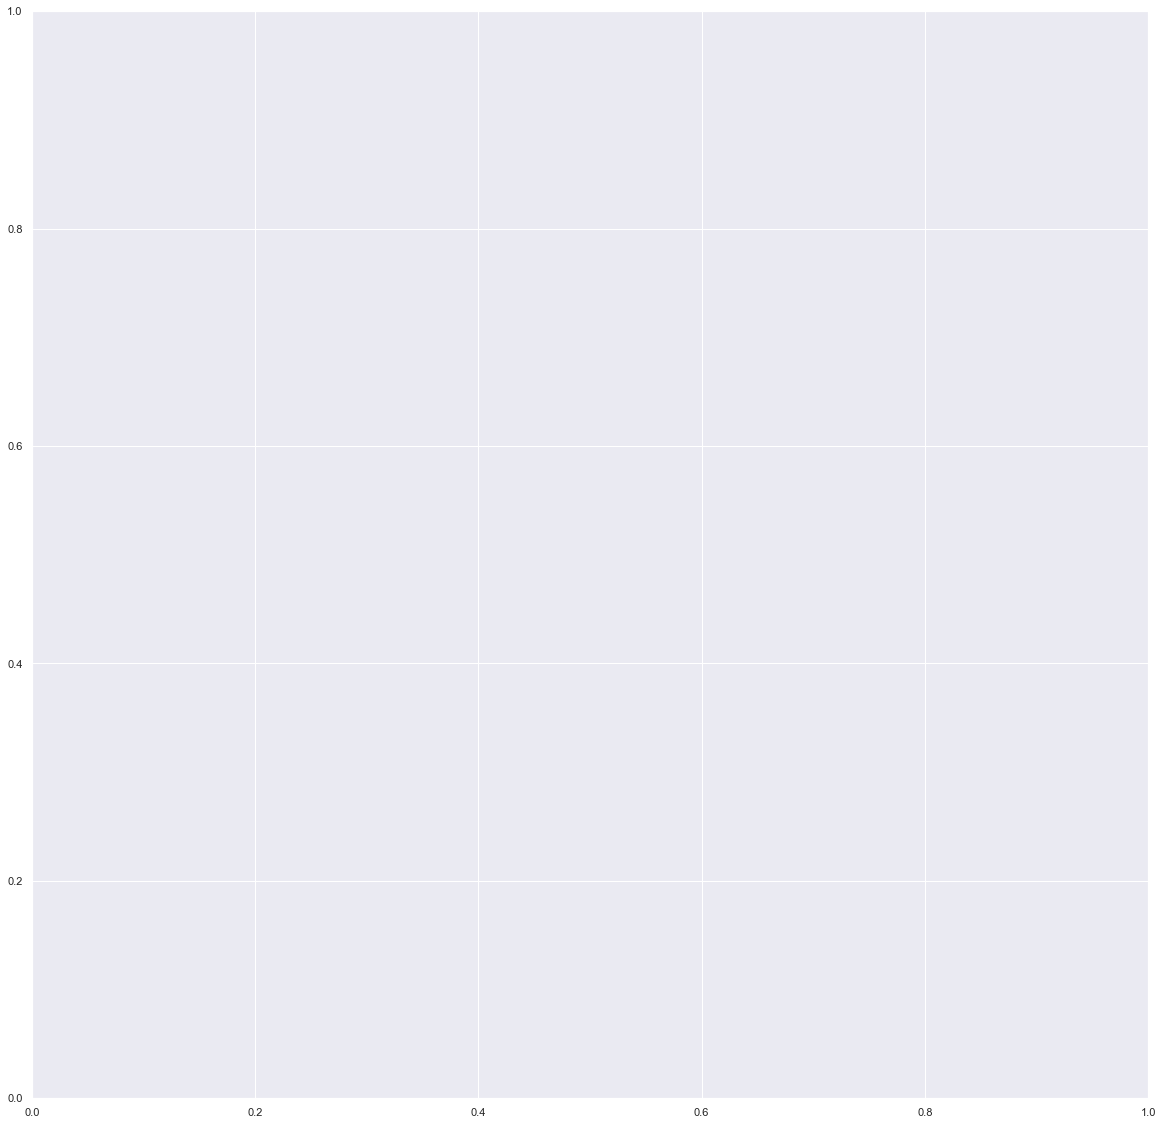

In [5]:
f, ax = plt.subplots(1, 1, figsize=(20, 20))
sns.pairplot(df_plot.drop(columns=["subject_id"]).reset_index(drop=True), kind="scatter", corner=True, hue="sampling", plot_kws={'alpha': 0.5})

plt.savefig("./scatter_corr_resampl.png", dpi=320)

In [4]:
df

,subject_id,2h_index,heart rate,systolic blood pressure,diastolic blood pressure,respiratory rate,oxygen saturation
1154,49,0,69.458333,101.00,52.041667,10.450000,99.833333
1155,49,1,71.875000,103.75,51.875000,13.875000,98.791667
1156,49,2,72.166667,103.00,53.666667,13.166667,99.083333
1157,49,3,80.500000,98.50,50.750000,15.500000,98.625000
1158,49,4,87.250000,104.75,49.250000,16.500000,96.900000
...,...,...,...,...,...,...,...
1108750,99946,5,96.500000,151.00,103.500000,11.500000,97.500000
1108751,99946,6,91.000000,143.50,98.500000,12.000000,98.000000
1108752,99946,7,99.000000,143.50,97.500000,13.500000,93.500000
1108753,99946,8,94.000000,135.00,91.000000,14.000000,93.000000


In [4]:
df_combo_sets = pd.read_csv("./combo_miss_rate_feats.csv", index_col=0)

In [5]:
df_combo_sets

,combo_set,features,n_patients,sampling
0,0,['heart rate'],480,1
1,1,"['systolic blood pressure', 'heart rate']",255,1
2,2,"['diastolic blood pressure', 'systolic blood p...",254,1
3,3,"['mean blood pressure', 'diastolic blood press...",236,1
4,4,"['respiratory rate', 'mean blood pressure', 'd...",209,1
5,5,"['oxygen saturation', 'respiratory rate', 'mea...",160,1
6,6,"['temperature', 'oxygen saturation', 'respirat...",2,1
0,0,['heart rate'],5383,2
1,1,"['systolic blood pressure', 'heart rate']",4452,2
2,2,"['diastolic blood pressure', 'systolic blood p...",4446,2


In [2]:
planets = sns.load_dataset("planets")

In [3]:
planets

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300000,7.10,77.40,2006
1,Radial Velocity,1,874.774000,2.21,56.95,2008
2,Radial Velocity,1,763.000000,2.60,19.84,2011
3,Radial Velocity,1,326.030000,19.40,110.62,2007
4,Radial Velocity,1,516.220000,10.50,119.47,2009
...,...,...,...,...,...,...
1030,Transit,1,3.941507,NaN,172.00,2006
1031,Transit,1,2.615864,NaN,148.00,2007
1032,Transit,1,3.191524,NaN,174.00,2007
1033,Transit,1,4.125083,NaN,293.00,2008


In [2]:
# plot missing rates
df = data_loader.data_meas

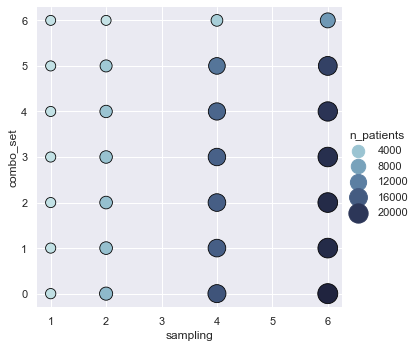

In [27]:
from matplotlib.colors import LogNorm

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.relplot(
    data=df_combo_sets,
    x="sampling", y="combo_set",
    size="n_patients", hue="n_patients",
    palette=cmap, sizes=(100, 400),
    edgecolor='black',
    legend="brief"
)
#g.set(xscale="log", yscale="log")
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
g.despine(left=True, bottom=True)

In [4]:
sampling_intervals = [2,4,6]

In [5]:
df_6 = df
df_6["sample_index"] = df_6.groupby(["subject_id"]).cumcount()//6

In [7]:
df_6 = df_6.groupby(["subject_id", "sample_index"]).mean().reset_index()

In [8]:
df_6

LEVEL2,subject_id,sample_index,hadm_id,icustay_id,hours_in,alanine aminotransferase,albumin,albumin ascites,albumin pleural,albumin urine,...,total protein,total protein urine,troponin-i,troponin-t,venous pvo2,weight,white blood cell count,white blood cell count urine,ph,ph urine
0,3,0,145834.0,211552.0,2.5,25.0,1.8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.842857,NaN,7.316667,5.0
1,3,1,145834.0,211552.0,8.5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,24.400000,35.0,7.315000,5.0
2,3,2,145834.0,211552.0,14.5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.398750,5.0
3,3,3,145834.0,211552.0,20.5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,106.00000,18.800000,NaN,7.371250,NaN
4,3,4,145834.0,211552.0,26.5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,35.0,NaN,NaN,NaN,7.407250,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381293,99999,0,113369.0,246512.0,2.5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,96.39883,12.400000,NaN,NaN,NaN
381294,99999,1,113369.0,246512.0,8.5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
381295,99999,2,113369.0,246512.0,14.5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,9.300000,NaN,NaN,NaN
381296,99999,3,113369.0,246512.0,20.5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
#TODO calculate for multiple sampling intervals and display 

df_missing_none = (df[features].isna().sum()/len(df)).reset_index(name="missing_rate_none")
df_missing_6 = (df_6[features].isna().sum()/len(df_6)).reset_index(name="missing_rate_6")

In [48]:
df_plot = df_missing_6.merge(df_missing_none)

In [49]:
df_plot

,LEVEL2,missing_rate_6,missing_rate_none
0,alanine aminotransferase,0.911678,0.980273
1,albumin,0.939444,0.986978
2,albumin ascites,0.999701,0.999948
3,albumin pleural,0.999617,0.999934
4,albumin urine,0.999656,0.999940
...,...,...,...
99,weight,0.855452,0.971895
100,white blood cell count,0.654027,0.918743
101,white blood cell count urine,0.985555,0.997467
102,ph,0.715141,0.908618


In [50]:
df_plot = df_plot.sort_values("missing_rate_none").reset_index().drop(columns=["index"])

In [51]:
df_plot

,LEVEL2,missing_rate_6,missing_rate_none
0,heart rate,0.044202,0.104139
1,respiratory rate,0.050787,0.118358
2,systolic blood pressure,0.047252,0.132583
3,diastolic blood pressure,0.047325,0.132797
4,mean blood pressure,0.050242,0.137121
...,...,...,...
99,albumin ascites,0.999701,0.999948
100,creatinine ascites,0.999832,0.999971
101,lymphocytes atypical csl,0.999890,0.999981
102,creatinine pleural,0.999892,0.999981


<AxesSubplot:>

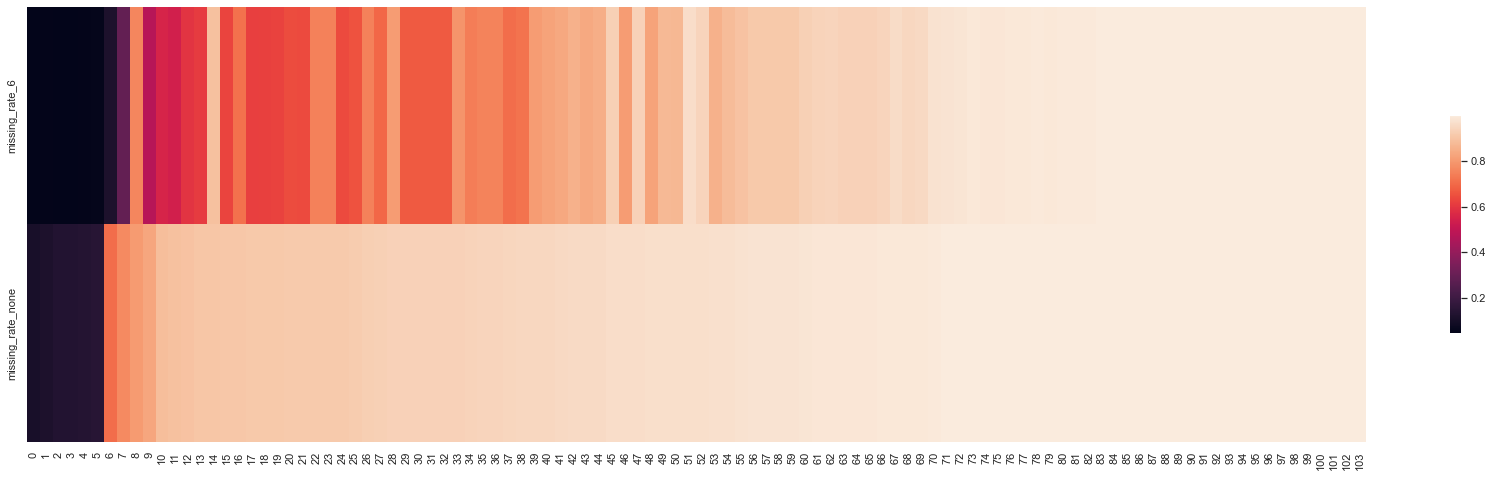

In [52]:
fig, ax = plt.subplots(figsize=(30,8))
sns.heatmap(df_plot.drop(columns="LEVEL2").T, ax=ax, cbar_kws={"shrink": 0.5})

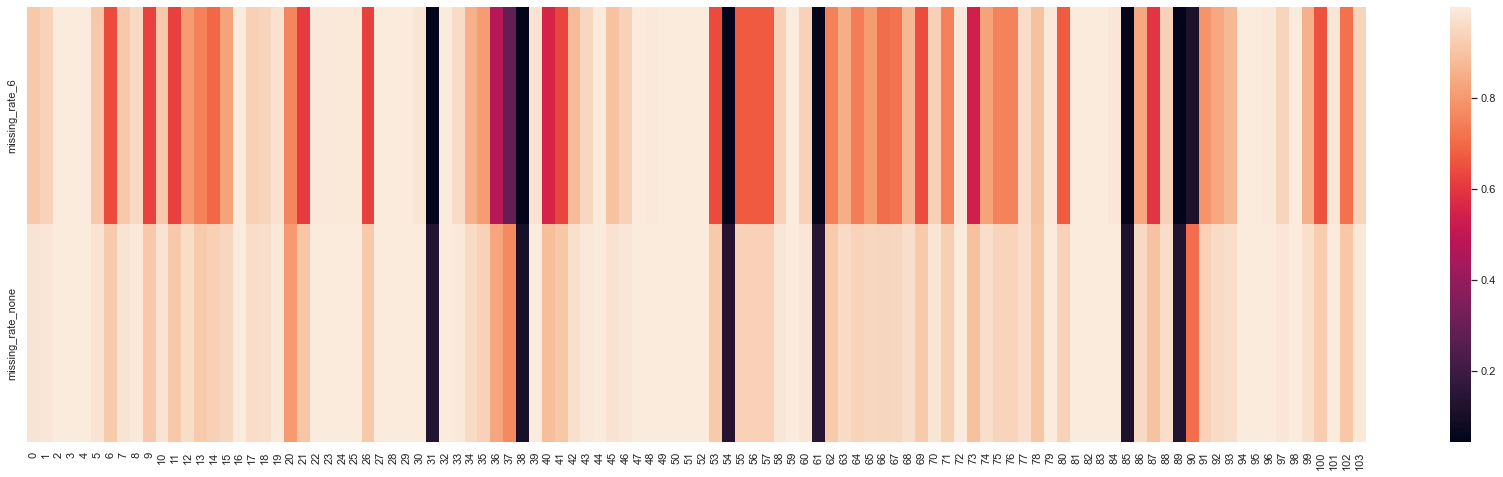

In [31]:
fig